 Sentiment analysis with spacy
    In this section, we'll work on a real-world dataset and train spaCy's TextCategorizer on this dataset. We'll be working on the Amazon Fine Food Reviews dataset 

In [4]:
#extract zip file
import zipfile
with zipfile.ZipFile("data/Reviews.zip", "r") as zip_ref:
    zip_ref.extractall("./data")

In [2]:
#Exploring the dataset
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
reviews_df = pd.read_csv("data/Reviews.csv")
reviews_df.head()

Id   ProductId          UserId                    ProfileName  \
0   50057  B000ER5DFQ  A1ESDLEDR9Y0JX                     A. Spencer   
1  366917  B001AIQP8M  A324KM3YY1DWQG                      danitrice   
2  214380  B001E5E1XW  A3QCWO53N69HW3  M. A. Vaughan "-_-GOBNOGO-_-"   
3  178476  B000TIZP5I   AYZ5NG9705AG1                       Consumer   
4  542504  B000E18CVE  A2LMWCJUF5HZ4Z             Miki Lam "mikilam"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       2      1  1310256000   
1                     0                       0      5  1251072000   
2                     2                       2      5  1276473600   
3                     0                       0      5  1341360000   
4                     8                      11      3  1222732800   

                                      Summary  \
0  the garbanzo beans in it give horrible gas   
1                      Yummy Lil' Treasures!!   
2                                  Great Chai   
3               Celtic Salt worth extra price   
4                              mixed feelings   

                                                Text  
0  To be fair only one of my twins got gas from t...  
1  Just recieved our first order of these (they d...  
2  This is a fantastic Chai Masala. I am very pic...  
3  Flavorful and has added nutrition!  You use le...  
4  I thought this soup tasted good. I liked the t...

In [8]:
reviews_df.shape

(3999, 10)

In [10]:
reviews_df.isnull().sum()

Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64

In [12]:
#drop missing values
reviews_df = reviews_df[['Text', 'Score']].dropna()

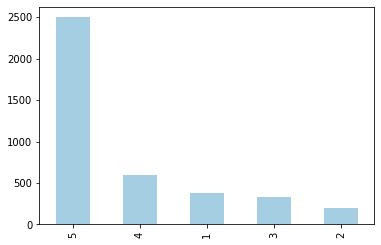

In [15]:
#quick look how review scores are distributed
ax = reviews_df.Score.value_counts().plot(kind='bar', cmap='Paired')
plt.show()

C:\Users\acer\AppData\Local\Temp/ipykernel_11240/3265582658.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df.Score[reviews_df.Score <= 3] = 0
C:\Users\acer\AppData\Local\Temp/ipykernel_11240/3265582658.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df.Score[reviews_df.Score >= 4] = 1


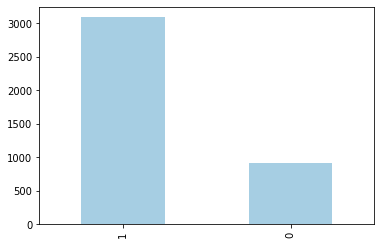

In [17]:
# from chart, imbalance occur and create trouble for classification
#So to handl imbalance, up-sampling/down-sampling

reviews_df.Score[reviews_df.Score <= 3] = 0
reviews_df.Score[reviews_df.Score >= 4] = 1

#let see distribution range again
ax = reviews_df.Score.value_counts().plot(kind='bar', cmap="Paired")

In [18]:
reviews_df.head()

Text  Score
0  To be fair only one of my twins got gas from t...      0
1  Just recieved our first order of these (they d...      1
2  This is a fantastic Chai Masala. I am very pic...      1
3  Flavorful and has added nutrition!  You use le...      1
4  I thought this soup tasted good. I liked the t...      0

In [19]:
#training the textclassifier component
import spacy
import random
from spacy.training import Example
from spacy.pipeline.textcat_multilabel import DEFAULT_MULTI_TEXTCAT_MODEL

nlp = spacy.load("en_core_web_md")

config = {
    "threshold": 0.5,
    "model": DEFAULT_MULTI_TEXTCAT_MODEL
}
textcat = nlp.add_pipe("textcat_multilabel", config = config)

In [22]:
#convert training sentences and rating into spacy usable format
train_examples = []

for index, row in reviews_df.iterrows():
    text = row['Text']
    rating = row['Score']
    label = {"POS": True, "NEG": False} if rating == 1 else {"NEG": True, "POS": False}
    train_examples.append(Example.from_dict(nlp.make_doc(text),
                                            {"cats": label}))
train_examples

[{'doc_annotation': {'cats': {'NEG': True, 'POS': False}, 'entities': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], 'links': {}}, 'token_annotation': {'ORTH': ['To', 'be', 'fair', 'only', 'one', 'of', 'my', 'twins', 'got', 'gas', 'from', 'this', 'but', 'it', 'was', 'horrible', '.', 'Up', 'all', 'night', 'screaming', 'from', 'gas', 'pains', '.', 'Garbanzo', 'beans', 'are', 'not', 'an', 'ideal', 'food', 'for', 'young', 'babies', '.'], 'SPACY': [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, False, False], 'TAG': ['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ''], 'LEMMA': ['', '', '', '', '', '', '', '', '

In [23]:
#use pos and neg label for pos and neg sentiment
textcat.add_label("POS")
textcat.add_label("NEG")
textcat.initialize(lambda: train_examples, nlp = nlp)

In [24]:
#define training loop
epochs = 2

with nlp.select_pipes(enable="textcat_multilabel"):
    optimizer = nlp.resume_training()
    for i in range(epochs):
        random.shuffle(train_examples)
        for example in train_examples:
            print(nlp.update([example], sgd=optimizer))

{'textcat_multilabel': 0.001959970686584711}
{'textcat_multilabel': 1.4829113483428955}
{'textcat_multilabel': 1.1240208148956299}
{'textcat_multilabel': 1.1463494300842285}
{'textcat_multilabel': 0.5612407922744751}
{'textcat_multilabel': 0.9604904055595398}
{'textcat_multilabel': 0.4451945424079895}
{'textcat_multilabel': 0.3648890554904938}
{'textcat_multilabel': 0.0971720740199089}
{'textcat_multilabel': 0.18331432342529297}
{'textcat_multilabel': 1.4675626754760742}
{'textcat_multilabel': 0.03218972310423851}
{'textcat_multilabel': 0.04342448711395264}
{'textcat_multilabel': 0.01850876957178116}
{'textcat_multilabel': 0.008195620961487293}
{'textcat_multilabel': 0.0018047848716378212}
{'textcat_multilabel': 0.0016541308723390102}
{'textcat_multilabel': 1.7807286977767944}
{'textcat_multilabel': 0.003496555844321847}
{'textcat_multilabel': 0.00020397859043441713}
{'textcat_multilabel': 0.010437424294650555}
{'textcat_multilabel': 1.7340686321258545}
{'textcat_multilabel': 0.0362247

{'textcat_multilabel': 0.0005319691263139248}
{'textcat_multilabel': 1.9635347127914429}
{'textcat_multilabel': 1.9591636657714844}
{'textcat_multilabel': 1.9411169290542603}
{'textcat_multilabel': 1.9818745851516724}
{'textcat_multilabel': 0.001077126944437623}
{'textcat_multilabel': 0.06385926902294159}
{'textcat_multilabel': 0.02281443029642105}
{'textcat_multilabel': 1.7450714111328125}
{'textcat_multilabel': 0.01342511922121048}
{'textcat_multilabel': 9.742216934682801e-05}
{'textcat_multilabel': 0.003909188788384199}
{'textcat_multilabel': 3.323971759527922e-05}
{'textcat_multilabel': 0.008207244798541069}
{'textcat_multilabel': 0.018987001851201057}
{'textcat_multilabel': 0.0005799902137368917}
{'textcat_multilabel': 0.003920453600585461}
{'textcat_multilabel': 0.028680747374892235}
{'textcat_multilabel': 0.0048660351894795895}
{'textcat_multilabel': 0.009170634672045708}
{'textcat_multilabel': 0.0005190674564801157}
{'textcat_multilabel': 1.7746295928955078}
{'textcat_multilabe

{'textcat_multilabel': 0.06868547946214676}
{'textcat_multilabel': 0.0010633174097165465}
{'textcat_multilabel': 0.17262884974479675}
{'textcat_multilabel': 3.891065716743469e-05}
{'textcat_multilabel': 9.69998654909432e-05}
{'textcat_multilabel': 1.1169136996613815e-05}
{'textcat_multilabel': 1.4726708286616486e-05}
{'textcat_multilabel': 5.540114500490745e-08}
{'textcat_multilabel': 2.1226389435469173e-05}
{'textcat_multilabel': 1.1776454448699951}
{'textcat_multilabel': 3.740861211554147e-05}
{'textcat_multilabel': 8.622603672847617e-06}
{'textcat_multilabel': 1.60785973072052}
{'textcat_multilabel': 1.3499128818511963}
{'textcat_multilabel': 5.287283056532033e-05}
{'textcat_multilabel': 0.1263151317834854}
{'textcat_multilabel': 1.8370294570922852}
{'textcat_multilabel': 6.350166950142011e-05}
{'textcat_multilabel': 0.00182002829387784}
{'textcat_multilabel': 0.0003044097975362092}
{'textcat_multilabel': 4.6963454224169254e-05}
{'textcat_multilabel': 6.005185059620999e-05}
{'textca

{'textcat_multilabel': 0.02726227417588234}
{'textcat_multilabel': 0.0040642693638801575}
{'textcat_multilabel': 0.9948568940162659}
{'textcat_multilabel': 0.003311211708933115}
{'textcat_multilabel': 0.00253646750934422}
{'textcat_multilabel': 0.10180005431175232}
{'textcat_multilabel': 0.028439564630389214}
{'textcat_multilabel': 0.0002858865773305297}
{'textcat_multilabel': 0.0010542463278397918}
{'textcat_multilabel': 0.3565245270729065}
{'textcat_multilabel': 0.00018344816635362804}
{'textcat_multilabel': 0.0019689369946718216}
{'textcat_multilabel': 2.9455241019604728e-05}
{'textcat_multilabel': 0.023332228884100914}
{'textcat_multilabel': 1.7249347365577705e-05}
{'textcat_multilabel': 0.00023063539993017912}
{'textcat_multilabel': 0.005200649611651897}
{'textcat_multilabel': 1.9721639156341553}
{'textcat_multilabel': 0.0002475162618793547}
{'textcat_multilabel': 1.9706133604049683}
{'textcat_multilabel': 4.2270199628546834e-05}
{'textcat_multilabel': 0.00011529598123161122}
{'te

{'textcat_multilabel': 0.7894748449325562}
{'textcat_multilabel': 0.0016098966589197516}
{'textcat_multilabel': 1.4642064571380615}
{'textcat_multilabel': 0.2864958345890045}
{'textcat_multilabel': 0.027042439207434654}
{'textcat_multilabel': 0.17188633978366852}
{'textcat_multilabel': 0.5852392911911011}
{'textcat_multilabel': 0.11201862245798111}
{'textcat_multilabel': 0.1494535505771637}
{'textcat_multilabel': 1.0634119510650635}
{'textcat_multilabel': 0.028918448835611343}
{'textcat_multilabel': 0.00192572723608464}
{'textcat_multilabel': 1.8596439361572266}
{'textcat_multilabel': 0.0005594177055172622}
{'textcat_multilabel': 0.001754881115630269}
{'textcat_multilabel': 1.9043956995010376}
{'textcat_multilabel': 0.07466551661491394}
{'textcat_multilabel': 0.0019131412263959646}
{'textcat_multilabel': 0.00024921310250647366}
{'textcat_multilabel': 0.1104738637804985}
{'textcat_multilabel': 0.006461274344474077}
{'textcat_multilabel': 0.7654682397842407}
{'textcat_multilabel': 0.8124

{'textcat_multilabel': 0.0009381787967868149}
{'textcat_multilabel': 0.00012513702677097172}
{'textcat_multilabel': 1.9512028694152832}
{'textcat_multilabel': 7.629223546246067e-06}
{'textcat_multilabel': 0.0008911807090044022}
{'textcat_multilabel': 1.971684217453003}
{'textcat_multilabel': 8.96050114533864e-05}
{'textcat_multilabel': 0.00048047196469269693}
{'textcat_multilabel': 0.001884100609458983}
{'textcat_multilabel': 3.172399374307133e-05}
{'textcat_multilabel': 1.9959070682525635}
{'textcat_multilabel': 0.0022976368200033903}
{'textcat_multilabel': 0.006171330343931913}
{'textcat_multilabel': 0.0004940941580571234}
{'textcat_multilabel': 1.4151792526245117}
{'textcat_multilabel': 2.316508016519947e-06}
{'textcat_multilabel': 4.1267790948040783e-05}
{'textcat_multilabel': 0.0003035965492017567}
{'textcat_multilabel': 2.031147960224189e-05}
{'textcat_multilabel': 0.0011351320426911116}
{'textcat_multilabel': 0.0012517948634922504}
{'textcat_multilabel': 0.0001819761673687026}
{

{'textcat_multilabel': 0.01420853566378355}
{'textcat_multilabel': 0.016318172216415405}
{'textcat_multilabel': 0.0003331914485897869}
{'textcat_multilabel': 0.008356117643415928}
{'textcat_multilabel': 7.90582416811958e-05}
{'textcat_multilabel': 0.4065837264060974}
{'textcat_multilabel': 2.4372066036448814e-05}
{'textcat_multilabel': 1.922516107559204}
{'textcat_multilabel': 1.4691786766052246}
{'textcat_multilabel': 1.32939858303871e-05}
{'textcat_multilabel': 0.21014511585235596}
{'textcat_multilabel': 8.163483471435029e-07}
{'textcat_multilabel': 0.0012414723169058561}
{'textcat_multilabel': 3.219602149329148e-05}
{'textcat_multilabel': 0.0005591293447650969}
{'textcat_multilabel': 0.00210581230930984}
{'textcat_multilabel': 0.0005312749999575317}
{'textcat_multilabel': 0.0011129042832180858}
{'textcat_multilabel': 0.0029307249933481216}
{'textcat_multilabel': 0.000586632639169693}
{'textcat_multilabel': 0.0002214781561633572}
{'textcat_multilabel': 0.00028870548703707755}
{'textc

{'textcat_multilabel': 0.7956845760345459}
{'textcat_multilabel': 0.038732923567295074}
{'textcat_multilabel': 0.001728181028738618}
{'textcat_multilabel': 0.02188107743859291}
{'textcat_multilabel': 1.2798670530319214}
{'textcat_multilabel': 0.019051628187298775}
{'textcat_multilabel': 0.256189227104187}
{'textcat_multilabel': 0.020003963261842728}
{'textcat_multilabel': 0.05347131937742233}
{'textcat_multilabel': 0.0004968985449522734}
{'textcat_multilabel': 0.7662073373794556}
{'textcat_multilabel': 1.2493274211883545}
{'textcat_multilabel': 0.004470680374652147}
{'textcat_multilabel': 0.10308706760406494}
{'textcat_multilabel': 0.10119892656803131}
{'textcat_multilabel': 0.8786438703536987}
{'textcat_multilabel': 0.24151362478733063}
{'textcat_multilabel': 1.5218815803527832}
{'textcat_multilabel': 0.1711972951889038}
{'textcat_multilabel': 0.0585758350789547}
{'textcat_multilabel': 0.09639765322208405}
{'textcat_multilabel': 0.41983479261398315}
{'textcat_multilabel': 0.0227293390

{'textcat_multilabel': 1.9693694114685059}
{'textcat_multilabel': 0.7607489228248596}
{'textcat_multilabel': 0.05585005506873131}
{'textcat_multilabel': 0.7757006287574768}
{'textcat_multilabel': 1.1707618236541748}
{'textcat_multilabel': 0.00010267727338941768}
{'textcat_multilabel': 1.2865879535675049}
{'textcat_multilabel': 0.018383527174592018}
{'textcat_multilabel': 0.23088917136192322}
{'textcat_multilabel': 0.3153722882270813}
{'textcat_multilabel': 1.808131217956543}
{'textcat_multilabel': 0.35106492042541504}
{'textcat_multilabel': 0.6404432058334351}
{'textcat_multilabel': 0.39465105533599854}
{'textcat_multilabel': 0.21080198884010315}
{'textcat_multilabel': 0.16170638799667358}
{'textcat_multilabel': 0.49844563007354736}
{'textcat_multilabel': 0.4619317054748535}
{'textcat_multilabel': 0.9918508529663086}
{'textcat_multilabel': 0.6176402568817139}
{'textcat_multilabel': 0.11389276385307312}
{'textcat_multilabel': 0.4885496497154236}
{'textcat_multilabel': 0.0008890884928405

{'textcat_multilabel': 0.035875104367733}
{'textcat_multilabel': 0.020901694893836975}
{'textcat_multilabel': 0.26993000507354736}
{'textcat_multilabel': 0.01010370533913374}
{'textcat_multilabel': 0.311157763004303}
{'textcat_multilabel': 0.0030223194044083357}
{'textcat_multilabel': 0.08106499165296555}
{'textcat_multilabel': 0.0017409806605428457}
{'textcat_multilabel': 1.2901133298873901}
{'textcat_multilabel': 0.030173830687999725}
{'textcat_multilabel': 0.0037335590459406376}
{'textcat_multilabel': 0.0005020133103244007}
{'textcat_multilabel': 0.029223021119832993}
{'textcat_multilabel': 0.0020127499010413885}
{'textcat_multilabel': 0.002000063192099333}
{'textcat_multilabel': 0.0014898465014994144}
{'textcat_multilabel': 0.0002752576838247478}
{'textcat_multilabel': 1.0632400512695312}
{'textcat_multilabel': 0.00022722304856870323}
{'textcat_multilabel': 1.9461212158203125}
{'textcat_multilabel': 0.9395530819892883}
{'textcat_multilabel': 0.012971019372344017}
{'textcat_multilab

{'textcat_multilabel': 0.0005531319184228778}
{'textcat_multilabel': 0.002233398612588644}
{'textcat_multilabel': 0.0003598979383241385}
{'textcat_multilabel': 1.9086673259735107}
{'textcat_multilabel': 0.0012975952122360468}
{'textcat_multilabel': 1.944843053817749}
{'textcat_multilabel': 9.005854371935129e-05}
{'textcat_multilabel': 0.0060138884000480175}
{'textcat_multilabel': 0.0004960683872923255}
{'textcat_multilabel': 0.0019257190870121121}
{'textcat_multilabel': 1.4909088611602783}
{'textcat_multilabel': 0.0009468945791013539}
{'textcat_multilabel': 0.0006543425261043012}
{'textcat_multilabel': 0.0004411853151395917}
{'textcat_multilabel': 0.005084741860628128}
{'textcat_multilabel': 2.9027427444816567e-05}
{'textcat_multilabel': 0.00021574617130681872}
{'textcat_multilabel': 0.00561930425465107}
{'textcat_multilabel': 1.8544954061508179}
{'textcat_multilabel': 0.00428034458309412}
{'textcat_multilabel': 1.8601547479629517}
{'textcat_multilabel': 0.009929008781909943}
{'textcat

{'textcat_multilabel': 1.638810634613037}
{'textcat_multilabel': 0.02640846185386181}
{'textcat_multilabel': 0.0067990971729159355}
{'textcat_multilabel': 0.0023752241395413876}
{'textcat_multilabel': 0.041501954197883606}
{'textcat_multilabel': 0.053675778210163116}
{'textcat_multilabel': 1.3820812702178955}
{'textcat_multilabel': 0.9295752644538879}
{'textcat_multilabel': 0.34139710664749146}
{'textcat_multilabel': 0.05106727033853531}
{'textcat_multilabel': 0.09963825345039368}
{'textcat_multilabel': 0.0004102410457562655}
{'textcat_multilabel': 0.05468294024467468}
{'textcat_multilabel': 0.012665338814258575}
{'textcat_multilabel': 0.7146589756011963}
{'textcat_multilabel': 0.3402897119522095}
{'textcat_multilabel': 0.40344342589378357}
{'textcat_multilabel': 0.08247122168540955}
{'textcat_multilabel': 0.6611119508743286}
{'textcat_multilabel': 1.237976312637329}
{'textcat_multilabel': 1.5045676231384277}
{'textcat_multilabel': 0.05856810137629509}
{'textcat_multilabel': 1.21503329

{'textcat_multilabel': 1.3376333713531494}
{'textcat_multilabel': 0.7103873491287231}
{'textcat_multilabel': 0.10733548551797867}
{'textcat_multilabel': 0.00044223846634849906}
{'textcat_multilabel': 0.5111020803451538}
{'textcat_multilabel': 0.0016610092716291547}
{'textcat_multilabel': 0.001338490634225309}
{'textcat_multilabel': 0.010311505757272243}
{'textcat_multilabel': 0.010196319781243801}
{'textcat_multilabel': 0.0002923671272583306}
{'textcat_multilabel': 0.0002939632395282388}
{'textcat_multilabel': 1.0807874202728271}
{'textcat_multilabel': 0.03068322315812111}
{'textcat_multilabel': 0.0010535370092839003}
{'textcat_multilabel': 0.07774548977613449}
{'textcat_multilabel': 0.00931321457028389}
{'textcat_multilabel': 0.0005792893352918327}
{'textcat_multilabel': 0.018125489354133606}
{'textcat_multilabel': 0.017766349017620087}
{'textcat_multilabel': 0.00429390836507082}
{'textcat_multilabel': 0.0007976157357916236}
{'textcat_multilabel': 1.952294111251831}
{'textcat_multilab

{'textcat_multilabel': 0.1565706729888916}
{'textcat_multilabel': 0.06740307807922363}
{'textcat_multilabel': 0.017215074971318245}
{'textcat_multilabel': 0.0017670358065515757}
{'textcat_multilabel': 0.0071518681943416595}
{'textcat_multilabel': 0.007629034109413624}
{'textcat_multilabel': 0.003478769911453128}
{'textcat_multilabel': 0.11872348189353943}
{'textcat_multilabel': 0.31214815378189087}
{'textcat_multilabel': 0.04113946855068207}
{'textcat_multilabel': 0.0077790203504264355}
{'textcat_multilabel': 0.020972324535250664}
{'textcat_multilabel': 0.23027744889259338}
{'textcat_multilabel': 1.1670188903808594}
{'textcat_multilabel': 1.2411088943481445}
{'textcat_multilabel': 0.005917600356042385}
{'textcat_multilabel': 1.0579582452774048}
{'textcat_multilabel': 0.04680493846535683}
{'textcat_multilabel': 0.08271175622940063}
{'textcat_multilabel': 0.0032606315799057484}
{'textcat_multilabel': 0.2481403350830078}
{'textcat_multilabel': 0.06528589129447937}
{'textcat_multilabel': 0

{'textcat_multilabel': 1.0852075815200806}
{'textcat_multilabel': 0.12285204231739044}
{'textcat_multilabel': 1.9729551076889038}
{'textcat_multilabel': 0.017968975007534027}
{'textcat_multilabel': 0.033670276403427124}
{'textcat_multilabel': 0.5370169878005981}
{'textcat_multilabel': 0.004253534134477377}
{'textcat_multilabel': 0.28180015087127686}
{'textcat_multilabel': 0.466225802898407}
{'textcat_multilabel': 0.0003147904062643647}
{'textcat_multilabel': 0.004791843704879284}
{'textcat_multilabel': 0.2715057134628296}
{'textcat_multilabel': 0.05482284352183342}
{'textcat_multilabel': 0.029299596324563026}
{'textcat_multilabel': 0.08899359405040741}
{'textcat_multilabel': 0.06851774454116821}
{'textcat_multilabel': 0.026874052360653877}
{'textcat_multilabel': 0.15301582217216492}
{'textcat_multilabel': 0.37906426191329956}
{'textcat_multilabel': 0.25088441371917725}
{'textcat_multilabel': 0.07389633357524872}
{'textcat_multilabel': 0.03721093386411667}
{'textcat_multilabel': 1.09784

{'textcat_multilabel': 0.0005082292482256889}
{'textcat_multilabel': 0.12359549105167389}


KeyboardInterrupt: 

In [27]:
#Finally the text classifier component works for tow eg sentences
doc2 = nlp("This is the best food I ever ate")
doc2.cats

{'POS': 0.9901505708694458, 'NEG': 0.00868241861462593}

In [30]:
doc3 = nlp("This food is the worst I ever ate")
doc3.cats

{'POS': 0.55083829164505, 'NEG': 0.1708555817604065}

In [28]:
doc4 = nlp("This meal is so terrible.")
doc4.cats

{'POS': 0.5571416616439819, 'NEG': 0.4533693492412567}

In [29]:
doc5 = nlp("So digusting")
doc5.cats

{'POS': 0.23621200025081635, 'NEG': 0.6484510898590088}